In [0]:
#not needed in databricks
from pyspark.sql import SparkSession
#create session
spark = SparkSession.builder.appName("IPL_Data_Analysis").getOrCreate()


####Access s3 bucket data directly without mounting

In [0]:
#generated keys in aws to access s3 bucket files and downloaded csv file for the same. Uploaded the csvn file containing keys in DBFS(uploaded from local machine) for security purpose
keys = spark.read.csv("dbfs:/FileStore/nirmal_dev_accessKeys.csv",inferSchema = True, header = True)
keys.printSchema()
access_key = keys.select("Access key ID").collect()[0][0]
secret_key = keys.select("Secret access key").collect()[0][0]

root
 |-- Access key ID: string (nullable = true)
 |-- Secret access key: string (nullable = true)



In [0]:
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)

In [0]:
match_df = spark.read.csv("s3://ipldatabucket2017/Match.csv",inferSchema = True, header = True)
ball_by_ball_df = spark.read.csv("s3://ipldatabucket2017/Ball_By_Ball.csv",inferSchema = True, header = True)
player_match_df = spark.read.csv("s3://ipldatabucket2017/Player_match.csv",inferSchema = True, header = True)
team_df = spark.read.csv("s3://ipldatabucket2017/Team.csv",inferSchema = True, header = True)
player_df = spark.read.csv("s3://ipldatabucket2017/Player.csv",inferSchema = True, header = True)

In [0]:
match_df.limit(10).display()
# ball_by_ball_df.display()
# player_match_df.display()
# team_df.display()
# player_df.display()

Match_SK,match_id,Team1,Team2,match_date,Season_Year,Venue_Name,City_Name,Country_Name,Toss_Winner,match_winner,Toss_Name,Win_Type,Outcome_Type,ManOfMach,Win_Margin,Country_id
0,335987,Royal Challengers Bangalore,Kolkata Knight Riders,2008-04-18,2008,M Chinnaswamy Stadium,Bangalore,India,Royal Challengers Bangalore,Kolkata Knight Riders,field,runs,Result,BB McCullum,140,1
1,335988,Kings XI Punjab,Chennai Super Kings,2008-04-19,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Chennai Super Kings,Chennai Super Kings,bat,runs,Result,MEK Hussey,33,1
2,335989,Delhi Daredevils,Rajasthan Royals,2008-04-19,2008,Feroz Shah Kotla,Delhi,India,Rajasthan Royals,Delhi Daredevils,bat,wickets,Result,MF Maharoof,9,1
3,335990,Mumbai Indians,Royal Challengers Bangalore,2008-04-20,2008,Wankhede Stadium,Mumbai,India,Mumbai Indians,Royal Challengers Bangalore,bat,wickets,Result,MV Boucher,5,1
4,335991,Kolkata Knight Riders,Deccan Chargers,2008-04-20,2008,Eden Gardens,Kolkata,India,Deccan Chargers,Kolkata Knight Riders,bat,wickets,Result,DJ Hussey,5,1
5,335992,Rajasthan Royals,Kings XI Punjab,2008-04-21,2008,Sawai Mansingh Stadium,Jaipur,India,Kings XI Punjab,Rajasthan Royals,bat,wickets,Result,SR Watson,6,1
6,335993,Deccan Chargers,Delhi Daredevils,2008-04-22,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Deccan Chargers,Delhi Daredevils,bat,wickets,Result,V Sehwag,9,1
7,335994,Chennai Super Kings,Mumbai Indians,2008-04-23,2008,"MA Chidambaram Stadium, Chepauk",Chennai,India,Mumbai Indians,Chennai Super Kings,field,runs,Result,ML Hayden,6,1
8,335995,Deccan Chargers,Rajasthan Royals,2008-04-24,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Rajasthan Royals,Rajasthan Royals,field,wickets,Result,YK Pathan,3,1
9,335996,Kings XI Punjab,Mumbai Indians,2008-04-25,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Mumbai Indians,Kings XI Punjab,field,runs,Result,KC Sangakkara,66,1


####Access s3 bucket data by mounting s3 bucket in databricks

In [0]:
encoded_secret_key = secret_key.replace("/","%2F")
bucket_name = "ipldatabucket2017"
mount_name = "s3_mount"
dbutils.fs.unmount(f"/mnt/{mount_name}") # to unmount
dbutils.fs.mount(f"s3a://{access_key}:{encoded_secret_key}@{bucket_name}",f"/mnt/{mount_name}")
display(dbutils.fs.ls(f"/mnt/{mount_name}"))

/mnt/s3_mount has been unmounted.


path,name,size,modificationTime
dbfs:/mnt/s3_mount/Ball_By_Ball.csv,Ball_By_Ball.csv,31232507,1730731514000
dbfs:/mnt/s3_mount/Match.csv,Match.csv,113322,1730731515000
dbfs:/mnt/s3_mount/Player.csv,Player.csv,34614,1730731515000
dbfs:/mnt/s3_mount/Player_match.csv,Player_match.csv,2770529,1730731522000
dbfs:/mnt/s3_mount/Team.csv,Team.csv,343,1730731523000


In [0]:
file_location = "dbfs:/mnt/s3_mount/Team.csv"
df = spark.read.csv(file_location,inferSchema = True, header = True)
df.limit(10).display()

Team_SK,Team_Id,Team_Name
0,1,Kolkata Knight Riders
1,2,Royal Challengers Bangalore
2,3,Chennai Super Kings
3,4,Kings XI Punjab
4,5,Rajasthan Royals
5,6,Delhi Daredevils
6,7,Mumbai Indians
7,8,Deccan Chargers
8,9,Kochi Tuskers Kerala
9,10,Pune Warriors


We might have mismatch of data types as we can't rely on spark's inferschema so we will create our own schema

In [0]:
from pyspark.sql.types import StructField,StructType,StringType,IntegerType,BooleanType,DateType,DecimalType

ball_by_ball_schema = StructType(
    [
        StructField("match_id", IntegerType(), True),
        StructField("over_id", IntegerType(), True), 
        StructField("ball_id", IntegerType(), True), 
        StructField("innings_no", IntegerType(), True), 
        StructField("team_batting", IntegerType(), True), 
        StructField("team_bowling", IntegerType(), True), 
        StructField("striker_batting_position", IntegerType(), True), 
        StructField("extra_type", StringType(), True), 
        StructField("runs_scored", IntegerType(), True), 
        StructField("extra_runs", IntegerType(), True), 
        StructField("wides", IntegerType(), True), 
        StructField("legbyes", IntegerType(), True), 
        StructField("byes", IntegerType(), True), 
        StructField("noballs", IntegerType(), True), 
        StructField("penalty", IntegerType(), True), 
        StructField("bowler_extras", IntegerType(), True), 
        StructField("out_type", StringType(), True), 
        StructField("caught", BooleanType(), True), 
        StructField("bowled", BooleanType(), True), 
        StructField("run_out", BooleanType(), True), 
        StructField("lbw", BooleanType(), True), 
        StructField("retired_hurt", BooleanType(), True), 
        StructField("stumped", BooleanType(), True), 
        StructField("caught_and_bowled", BooleanType(), True), 
        StructField("hit_wicket", BooleanType(), True), 
        StructField("obstructingfeild", BooleanType(), True), 
        StructField("bowler_wicket", BooleanType(), True), 
        StructField("match_date", DateType(), True), 
        StructField("season", IntegerType(), True), 
        StructField("striker", IntegerType(), True), 
        StructField("non_striker", IntegerType(), True), 
        StructField("bowler", IntegerType(), True), 
        StructField("player_out", IntegerType(), True), 
        StructField("fielders", IntegerType(), True), 
        StructField("striker_match_sk", IntegerType(), True), 
        StructField("strikersk", IntegerType(), True), 
        StructField("nonstriker_match_sk", IntegerType(), True), 
        StructField("nonstriker_sk", IntegerType(), True), 
        StructField("fielder_match_sk", IntegerType(), True), 
        StructField("fielder_sk", IntegerType(), True), 
        StructField("bowler_match_sk", IntegerType(), True), 
        StructField("bowler_sk", IntegerType(), True), 
        StructField("playerout_match_sk", IntegerType(), True), 
        StructField("battingteam_sk", IntegerType(), True), 
        StructField("bowlingteam_sk", IntegerType(), True), 
        StructField("keeper_catch", BooleanType(), True), 
        StructField("player_out_sk", IntegerType(), True), 
        StructField("matchdatesk", DateType(), True)
    ]
)

In [0]:
ball_by_ball_df = spark.read.format('csv')\
                            .option("header","true")\
                            .schema(ball_by_ball_schema)\
                            .option("dateFormat","M/d/y")\
                            .load("s3://ipldatabucket2017/Ball_By_Ball.csv")

ball_by_ball_df.limit(10).display()

match_id,over_id,ball_id,innings_no,team_batting,team_bowling,striker_batting_position,extra_type,runs_scored,extra_runs,wides,legbyes,byes,noballs,penalty,bowler_extras,out_type,caught,bowled,run_out,lbw,retired_hurt,stumped,caught_and_bowled,hit_wicket,obstructingfeild,bowler_wicket,match_date,season,striker,non_striker,bowler,player_out,fielders,striker_match_sk,strikersk,nonstriker_match_sk,nonstriker_sk,fielder_match_sk,fielder_sk,bowler_match_sk,bowler_sk,playerout_match_sk,battingteam_sk,bowlingteam_sk,keeper_catch,player_out_sk,matchdatesk
598028,15,6,1,5,2,6,No Extras,4,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,277,104,83,null,null,20336,276,20333,103,-1,-1,20343,82,-1,4,1,false,0,null
598028,14,1,1,5,2,5,No Extras,1,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,104,6,346,null,null,20333,103,20328,5,-1,-1,20348,345,-1,4,1,false,0,null
598028,14,2,1,5,2,3,No Extras,1,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,346,null,null,20328,5,20333,103,-1,-1,20348,345,-1,4,1,false,0,null
598028,14,3,1,5,2,5,No Extras,1,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,104,6,346,null,null,20333,103,20328,5,-1,-1,20348,345,-1,4,1,false,0,null
598028,14,4,1,5,2,3,No Extras,0,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,346,null,null,20328,5,20333,103,-1,-1,20348,345,-1,4,1,false,0,null
598028,14,5,1,5,2,3,No Extras,4,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,346,null,null,20328,5,20333,103,-1,-1,20348,345,-1,4,1,false,0,null
598028,14,6,1,5,2,3,No Extras,2,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,346,null,null,20328,5,20333,103,-1,-1,20348,345,-1,4,1,false,0,null
598028,13,1,1,5,2,5,No Extras,1,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,104,6,83,null,null,20333,103,20328,5,-1,-1,20343,82,-1,4,1,false,0,null
598028,13,2,1,5,2,3,No Extras,4,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,83,null,null,20328,5,20333,103,-1,-1,20343,82,-1,4,1,false,0,null
598028,13,3,1,5,2,3,No Extras,1,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2013-04-20,2013,6,104,83,null,null,20328,5,20333,103,-1,-1,20343,82,-1,4,1,false,0,null


In [0]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True), 
    StructField("match_id", IntegerType(), True), 
    StructField("team1", StringType(), True), 
    StructField("team2", StringType(), True), 
    StructField("match_date", DateType(), True), 
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True), 
    StructField("city_name", StringType(), True), 
    StructField("country_name", StringType(), True), 
    StructField("toss_winner", StringType(), True), 
    StructField("match_winner", StringType(), True), 
    StructField("toss_name", StringType(), True), 
    StructField("win_type", StringType(), True), 
    StructField("outcome_type", StringType(), True), 
    StructField("manofmach", StringType(), True), 
    StructField("win_margin", IntegerType(), True), 
    StructField("country_id", IntegerType(), True)
])

In [0]:
match_df = spark.read.format('csv')\
                            .option("header","true")\
                            .schema(match_schema)\
                            .option("dateFormat","M/d/y")\
                            .load("s3://ipldatabucket2017/Match.csv")

match_df.limit(10).display()

match_sk,match_id,team1,team2,match_date,season_year,venue_name,city_name,country_name,toss_winner,match_winner,toss_name,win_type,outcome_type,manofmach,win_margin,country_id
0,335987,Royal Challengers Bangalore,Kolkata Knight Riders,2008-04-18,2008,M Chinnaswamy Stadium,Bangalore,India,Royal Challengers Bangalore,Kolkata Knight Riders,field,runs,Result,BB McCullum,140,1
1,335988,Kings XI Punjab,Chennai Super Kings,2008-04-19,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Chennai Super Kings,Chennai Super Kings,bat,runs,Result,MEK Hussey,33,1
2,335989,Delhi Daredevils,Rajasthan Royals,2008-04-19,2008,Feroz Shah Kotla,Delhi,India,Rajasthan Royals,Delhi Daredevils,bat,wickets,Result,MF Maharoof,9,1
3,335990,Mumbai Indians,Royal Challengers Bangalore,2008-04-20,2008,Wankhede Stadium,Mumbai,India,Mumbai Indians,Royal Challengers Bangalore,bat,wickets,Result,MV Boucher,5,1
4,335991,Kolkata Knight Riders,Deccan Chargers,2008-04-20,2008,Eden Gardens,Kolkata,India,Deccan Chargers,Kolkata Knight Riders,bat,wickets,Result,DJ Hussey,5,1
5,335992,Rajasthan Royals,Kings XI Punjab,2008-04-21,2008,Sawai Mansingh Stadium,Jaipur,India,Kings XI Punjab,Rajasthan Royals,bat,wickets,Result,SR Watson,6,1
6,335993,Deccan Chargers,Delhi Daredevils,2008-04-22,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Deccan Chargers,Delhi Daredevils,bat,wickets,Result,V Sehwag,9,1
7,335994,Chennai Super Kings,Mumbai Indians,2008-04-23,2008,"MA Chidambaram Stadium, Chepauk",Chennai,India,Mumbai Indians,Chennai Super Kings,field,runs,Result,ML Hayden,6,1
8,335995,Deccan Chargers,Rajasthan Royals,2008-04-24,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Rajasthan Royals,Rajasthan Royals,field,wickets,Result,YK Pathan,3,1
9,335996,Kings XI Punjab,Mumbai Indians,2008-04-25,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Mumbai Indians,Kings XI Punjab,field,runs,Result,KC Sangakkara,66,1


In [0]:
match_df.select("match_winner").distinct().show()
match_df.select("toss_winner").distinct().show()

+--------------------+
|        match_winner|
+--------------------+
| Sunrisers Hyderabad|
| Chennai Super Kings|
|                tied|
|     Deccan Chargers|
|Kochi Tuskers Kerala|
|    Rajasthan Royals|
|       Gujarat Lions|
|Royal Challengers...|
|Kolkata Knight Ri...|
|           abandoned|
|Rising Pune Super...|
|     Kings XI Punjab|
|       Pune Warriors|
|    Delhi Daredevils|
|      Mumbai Indians|
|                NULL|
+--------------------+

+--------------------+
|         toss_winner|
+--------------------+
| Sunrisers Hyderabad|
| Chennai Super Kings|
|                null|
|Rising Pune Super...|
|     Deccan Chargers|
|Kochi Tuskers Kerala|
|    Rajasthan Royals|
|       Gujarat Lions|
|Royal Challengers...|
|Kolkata Knight Ri...|
|Rising Pune Super...|
|     Kings XI Punjab|
|       Pune Warriors|
|    Delhi Daredevils|
|      Mumbai Indians|
+--------------------+



In [0]:
#to handle null values in match df
match_df = match_df.fillna({'match_winner': 'Not Applied'})
match_df = match_df.fillna({'toss_winner': 'Not Applied'})

In [0]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True), 
    StructField("playermatch_key", StringType(), True), 
    StructField("match_id", DecimalType(), True), 
    StructField("player_id", IntegerType(), True), 
    StructField("player_name", StringType(), True), 
    StructField("dob", DateType(), True), 
    StructField("batting_hand", StringType(), True), 
    StructField("bowling_skill", StringType(), True), 
    StructField("country_name", StringType(), True), 
    StructField("role_desc", StringType(), True), 
    StructField("player_team", StringType(), True), 
    StructField("opposit_team", StringType(), True), 
    StructField("season_year", IntegerType(), True), # Use StringType() for year 
    StructField("is_manofthematch", BooleanType(), True), 
    StructField("age_as_on_match", IntegerType(), True), 
    StructField("isplayers_team_won", BooleanType(), True), 
    StructField("batting_status", StringType(), True), 
    StructField("bowling_status", StringType(), True), 
    StructField("player_captain", StringType(), True), 
    StructField("opposit_captain", StringType(), True), 
    StructField("player_keeper", StringType(), True), 
    StructField("opposit_keeper", StringType(), True)
])

In [0]:
player_match_df = spark.read.format('csv').option("header", "true")\
                                          .schema(player_match_schema)\
                                          .option("dateFormat",'M/d/y')\
                                          .load("s3://ipldatabucket2017/Player_match.csv")
player_match_df.limit(10).display()

player_match_sk,playermatch_key,match_id,player_id,player_name,dob,batting_hand,bowling_skill,country_name,role_desc,player_team,opposit_team,season_year,is_manofthematch,age_as_on_match,isplayers_team_won,batting_status,bowling_status,player_captain,opposit_captain,player_keeper,opposit_keeper
12694,33598700006,335987,6,R Dravid,1973-01-11,Right-hand bat,Right-arm offbreak,India,Captain,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,35,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12695,33598700007,335987,7,W Jaffer,1978-02-16,Right-hand bat,Right-arm offbreak,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,30,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12696,33598700008,335987,8,V Kohli,1988-11-05,Right-hand bat,Right-arm medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,20,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12697,33598700009,335987,9,JH Kallis,1975-10-16,Right-hand bat,Right-arm fast-medium,South Africa,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,33,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12698,33598700010,335987,10,CL White,1983-08-18,Right-hand bat,Legbreak googly,Australia,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,25,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12699,33598700011,335987,11,MV Boucher,1976-12-03,Right-hand bat,Right-arm medium,South Africa,Keeper,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,32,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12700,33598700012,335987,12,B Akhil,1977-10-07,Right-hand bat,Right-arm medium-fast,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,31,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12701,33598700013,335987,13,AA Noffke,1977-04-30,Right-hand bat,Right-arm fast-medium,Australia,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,31,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12702,33598700014,335987,14,P Kumar,1986-10-02,Right-hand bat,Right-arm medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,22,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha
12703,33598700015,335987,15,Z Khan,1978-10-07,Right-hand bat,Left-arm fast-medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,30,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha


In [0]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

In [0]:
team_df = spark.read.format('csv')\
                    .option("header","true")\
                    .schema(team_schema)\
                    .load('s3://ipldatabucket2017/Team.csv')

team_df.display()

team_sk,team_id,team_name
0,1,Kolkata Knight Riders
1,2,Royal Challengers Bangalore
2,3,Chennai Super Kings
3,4,Kings XI Punjab
4,5,Rajasthan Royals
5,6,Delhi Daredevils
6,7,Mumbai Indians
7,8,Deccan Chargers
8,9,Kochi Tuskers Kerala
9,10,Pune Warriors


In [0]:
player_schema = StructType([
    StructField("player_sk", IntegerType(),True),
    StructField("player_id", IntegerType(),True),
    StructField("player_name", StringType(),True),
    StructField("dob", DateType(),True),
    StructField("batting_hand", StringType(),True),
    StructField("bowling_skill", StringType(),True),
    StructField("country_name", StringType(),True),
])

In [0]:
player_df = spark.read.format('csv')\
                      .option('header',"true")\
                      .schema(player_schema)\
                      .option("dateFormat",'M/d/y')\
                      .load('s3://ipldatabucket2017/Player.csv')

player_df.limit(10).display()

player_sk,player_id,player_name,dob,batting_hand,bowling_skill,country_name
0,1,SC Ganguly,1972-07-08,Left-hand bat,Right-arm medium,India
1,2,BB McCullum,1981-09-27,Right-hand bat,Right-arm medium,New Zealand
2,3,RT Ponting,1974-12-19,Right-hand bat,Right-arm medium,Australia
3,4,DJ Hussey,1977-07-15,Right-hand bat,Right-arm offbreak,Australia
4,5,Mohammad Hafeez,1980-10-17,Right-hand bat,Right-arm offbreak,Pakistan
5,6,R Dravid,1973-01-11,Right-hand bat,Right-arm offbreak,India
6,7,W Jaffer,1978-02-16,Right-hand bat,Right-arm offbreak,India
7,8,V Kohli,1988-11-05,Right-hand bat,Right-arm medium,India
8,9,JH Kallis,1975-10-16,Right-hand bat,Right-arm fast-medium,South Africa
9,10,CL White,1983-08-18,Right-hand bat,Legbreak googly,Australia


####Spark Data Transformations to make it suitable for the analysis

In [0]:
from pyspark.sql.functions import *

#Filter to include only valid deliveries(excludng wide and no balls)
ball_by_ball_df = ball_by_ball_df.filter((col("wides") == 0) & (col("noballs") == 0))

#Aggregation : Calculate the total and average runs scored in each match and inning
total = ball_by_ball_df.groupBy("match_id","innings_no").agg(
    sum("runs_scored").alias("total_runs"),
    avg("runs_scored").alias("average_runs")
)

In [0]:
#Window Function : Calculate running total of runs in each match for each over
from pyspark.sql.window import Window
windowSpec = Window.partitionBy("match_id","innings_no").orderBy(col("over_id").desc())
ball_by_ball_df=ball_by_ball_df.withColumn("RunningRuns",sum("runs_scored").over(windowSpec))


In [0]:
 #Conditional Column : Flag for high impact balls (Either a wicket or more than 6 runs including extras)
 ball_by_ball_df = ball_by_ball_df.withColumn(
     "high_impact",
     when(
         (col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == True), True
     ).otherwise(False)
 )

In [0]:
ball_by_ball_df.limit(10).display()
#all transformations will happen when it's executed (Action) called lazy evaluation

match_id,over_id,ball_id,innings_no,team_batting,team_bowling,striker_batting_position,extra_type,runs_scored,extra_runs,wides,legbyes,byes,noballs,penalty,bowler_extras,out_type,caught,bowled,run_out,lbw,retired_hurt,stumped,caught_and_bowled,hit_wicket,obstructingfeild,bowler_wicket,match_date,season,striker,non_striker,bowler,player_out,fielders,striker_match_sk,strikersk,nonstriker_match_sk,nonstriker_sk,fielder_match_sk,fielder_sk,bowler_match_sk,bowler_sk,playerout_match_sk,battingteam_sk,bowlingteam_sk,keeper_catch,player_out_sk,matchdatesk,RunningRuns,high_impact
335987,20,1,1,1,2,2,No Extras,6,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,20,2,1,1,2,2,No Extras,6,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,20,3,1,1,2,2,No Extras,2,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,20,4,1,1,2,2,No Extras,0,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,20,5,1,1,2,2,No Extras,2,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,20,6,1,1,2,2,No Extras,6,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,14,null,null,12706,1,12709,4,-1,-1,12702,13,-1,0,1,false,0,null,22,false
335987,19,1,1,1,2,2,No Extras,6,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,9,null,null,12706,1,12709,4,-1,-1,12697,8,-1,0,1,false,0,null,43,false
335987,19,2,1,1,2,2,No Extras,0,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,9,null,null,12706,1,12709,4,-1,-1,12697,8,-1,0,1,false,0,null,43,false
335987,19,3,1,1,2,2,No Extras,6,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,9,null,null,12706,1,12709,4,-1,-1,12697,8,-1,0,1,false,0,null,43,false
335987,19,4,1,1,2,2,No Extras,4,0,0,0,0,0,0,0,Not Applicable,false,false,false,false,false,false,false,false,false,false,2008-04-18,2008,2,5,9,null,null,12706,1,12709,4,-1,-1,12697,8,-1,0,1,false,0,null,43,false


In [0]:
# Function to make a string into Short form (eg 'Royal Challengers Bangalore' into 'RCB'
def inShort(str):
    str = str.split(" ")
    lst = []
    for i in str:
        if(i not in ['tied','abandoned','NULL','null']):
            lst.append(i[0])
        else:
            lst.append(i)
    newStr =  ''.join(lst)
    return newStr
# inShort('nulls')
inShort_udf = udf(inShort, StringType())

In [0]:
from pyspark.sql.functions import year,month,dayofmonth,when

#extracting year,month, and day from the match date 
match_df = match_df.withColumn("year", year("match_date"))
match_df = match_df.withColumn("month", month("match_date"))
match_df = match_df.withColumn("day", dayofmonth("match_date"))

#High margin win:  categorizing win margins into high, medium, and low.
match_df = match_df.withColumn(
    "win_margin_category",
    when(col("win_margin") >= 100, 'High')
    .when((col("win_margin") >= 50) & (col("win_margin") < 100),'Medium')
    .otherwise('Low')
    )

#Analyse the impact of the toss : who wins the toss and the match
match_df = match_df.withColumn(
    "toss_match_winner",
    when(col('toss_winner') == col('match_winner'), "Yes").otherwise("No")
) 
#Adding column for Short Name of each team so that we can use efficiently in plotting graph
match_df = match_df.withColumn(
    "team1_in_short",
    inShort_udf(match_df["team1"])
) 
match_df = match_df.withColumn(
    "team2_in_short",
    inShort_udf(match_df["team2"])
) 
match_df = match_df.withColumn(
    "toss_winner_in_short",
    inShort_udf(match_df["toss_winner"])
) 
match_df = match_df.withColumn(
    "match_winner_in_short",
    inShort_udf(match_df["match_winner"])
) 


match_df.limit(10).display()


match_sk,match_id,team1,team2,match_date,season_year,venue_name,city_name,country_name,toss_winner,match_winner,toss_name,win_type,outcome_type,manofmach,win_margin,country_id,year,month,day,win_margin_category,toss_match_winner,team1_in_short,team2_in_short,toss_winner_in_short,match_winner_in_short
0,335987,Royal Challengers Bangalore,Kolkata Knight Riders,2008-04-18,2008,M Chinnaswamy Stadium,Bangalore,India,Royal Challengers Bangalore,Kolkata Knight Riders,field,runs,Result,BB McCullum,140,1,2008,4,18,High,No,RCB,KKR,RCB,KKR
1,335988,Kings XI Punjab,Chennai Super Kings,2008-04-19,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Chennai Super Kings,Chennai Super Kings,bat,runs,Result,MEK Hussey,33,1,2008,4,19,Low,Yes,KXP,CSK,CSK,CSK
2,335989,Delhi Daredevils,Rajasthan Royals,2008-04-19,2008,Feroz Shah Kotla,Delhi,India,Rajasthan Royals,Delhi Daredevils,bat,wickets,Result,MF Maharoof,9,1,2008,4,19,Low,No,DD,RR,RR,DD
3,335990,Mumbai Indians,Royal Challengers Bangalore,2008-04-20,2008,Wankhede Stadium,Mumbai,India,Mumbai Indians,Royal Challengers Bangalore,bat,wickets,Result,MV Boucher,5,1,2008,4,20,Low,No,MI,RCB,MI,RCB
4,335991,Kolkata Knight Riders,Deccan Chargers,2008-04-20,2008,Eden Gardens,Kolkata,India,Deccan Chargers,Kolkata Knight Riders,bat,wickets,Result,DJ Hussey,5,1,2008,4,20,Low,No,KKR,DC,DC,KKR
5,335992,Rajasthan Royals,Kings XI Punjab,2008-04-21,2008,Sawai Mansingh Stadium,Jaipur,India,Kings XI Punjab,Rajasthan Royals,bat,wickets,Result,SR Watson,6,1,2008,4,21,Low,No,RR,KXP,KXP,RR
6,335993,Deccan Chargers,Delhi Daredevils,2008-04-22,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Deccan Chargers,Delhi Daredevils,bat,wickets,Result,V Sehwag,9,1,2008,4,22,Low,No,DC,DD,DC,DD
7,335994,Chennai Super Kings,Mumbai Indians,2008-04-23,2008,"MA Chidambaram Stadium, Chepauk",Chennai,India,Mumbai Indians,Chennai Super Kings,field,runs,Result,ML Hayden,6,1,2008,4,23,Low,No,CSK,MI,MI,CSK
8,335995,Deccan Chargers,Rajasthan Royals,2008-04-24,2008,"Rajiv Gandhi International Stadium, Uppal",Hyderabad,India,Rajasthan Royals,Rajasthan Royals,field,wickets,Result,YK Pathan,3,1,2008,4,24,Low,Yes,DC,RR,RR,RR
9,335996,Kings XI Punjab,Mumbai Indians,2008-04-25,2008,"Punjab Cricket Association Stadium, Mohali",Chandigarh,India,Mumbai Indians,Kings XI Punjab,field,runs,Result,KC Sangakkara,66,1,2008,4,25,Medium,No,KXP,MI,MI,KXP


In [0]:
match_df.select('match_winner_in_short').distinct().show()
# match_df.select('match_winner').distinct().show()

+---------------------+
|match_winner_in_short|
+---------------------+
|                  KKR|
|                   DC|
|                   GL|
|                   RR|
|                  KXP|
|                   MI|
|                   DD|
|                 tied|
|                  CSK|
|                  RCB|
|            abandoned|
|                   SH|
|                  RPS|
|                  KTK|
|                   PW|
|                 NULL|
+---------------------+



In [0]:
player_df.select("batting_hand").distinct().show()

+---------------+
|   batting_hand|
+---------------+
|  Left-hand bat|
|�Right-hand bat|
| Right-hand bat|
| �Left-hand bat|
|   Right-handed|
+---------------+



In [0]:
from pyspark.sql.functions import lower,regexp_replace

#Normalise and clean batting_hand column values
player_df = player_df.withColumn(
    "batting_hand0",
    lower(regexp_replace("batting_hand", "[^a-zA-Z0-9]", "")) 
    #Here, it’s replacing any characters in batting hand col that are not letters (a-z, A-Z) or numbers (0-9) with an empty string, effectively removing them.
)
player_df = player_df.withColumn(
    "batting_hand_new",
    when(
        col("batting_hand0").contains("left"), "Left-handed"
    ).otherwise("Right-handed") #will only conatain two distinct values
)
player_df = player_df.drop("batting_hand0")

player_df.limit(10).display()

player_sk,player_id,player_name,dob,batting_hand,bowling_skill,country_name,batting_hand_new
0,1,SC Ganguly,1972-07-08,Left-hand bat,Right-arm medium,India,Left-handed
1,2,BB McCullum,1981-09-27,Right-hand bat,Right-arm medium,New Zealand,Right-handed
2,3,RT Ponting,1974-12-19,Right-hand bat,Right-arm medium,Australia,Right-handed
3,4,DJ Hussey,1977-07-15,Right-hand bat,Right-arm offbreak,Australia,Right-handed
4,5,Mohammad Hafeez,1980-10-17,Right-hand bat,Right-arm offbreak,Pakistan,Right-handed
5,6,R Dravid,1973-01-11,Right-hand bat,Right-arm offbreak,India,Right-handed
6,7,W Jaffer,1978-02-16,Right-hand bat,Right-arm offbreak,India,Right-handed
7,8,V Kohli,1988-11-05,Right-hand bat,Right-arm medium,India,Right-handed
8,9,JH Kallis,1975-10-16,Right-hand bat,Right-arm fast-medium,South Africa,Right-handed
9,10,CL White,1983-08-18,Right-hand bat,Legbreak googly,Australia,Right-handed


In [0]:
from pyspark.sql.functions import when,col,current_date

#Add veteran status column based on player's age
player_match_df = player_match_df.withColumn(
    "veteran_status",
    when(col("age_as_on_match") >=35, "Veteran").otherwise("Non-Vetran")
)

#Dynamic column to calculate year since debut
player_match_df = player_match_df.withColumn(
    "years_since_debut",
    (year(current_date()) - col("season_year"))
)

player_match_df.limit(10).display()

player_match_sk,playermatch_key,match_id,player_id,player_name,dob,batting_hand,bowling_skill,country_name,role_desc,player_team,opposit_team,season_year,is_manofthematch,age_as_on_match,isplayers_team_won,batting_status,bowling_status,player_captain,opposit_captain,player_keeper,opposit_keeper,veteran_status,years_since_debut
12694,33598700006,335987,6,R Dravid,1973-01-11,Right-hand bat,Right-arm offbreak,India,Captain,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,35,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Veteran,16
12695,33598700007,335987,7,W Jaffer,1978-02-16,Right-hand bat,Right-arm offbreak,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,30,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12696,33598700008,335987,8,V Kohli,1988-11-05,Right-hand bat,Right-arm medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,20,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12697,33598700009,335987,9,JH Kallis,1975-10-16,Right-hand bat,Right-arm fast-medium,South Africa,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,33,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12698,33598700010,335987,10,CL White,1983-08-18,Right-hand bat,Legbreak googly,Australia,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,25,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12699,33598700011,335987,11,MV Boucher,1976-12-03,Right-hand bat,Right-arm medium,South Africa,Keeper,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,32,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12700,33598700012,335987,12,B Akhil,1977-10-07,Right-hand bat,Right-arm medium-fast,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,31,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12701,33598700013,335987,13,AA Noffke,1977-04-30,Right-hand bat,Right-arm fast-medium,Australia,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,31,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12702,33598700014,335987,14,P Kumar,1986-10-02,Right-hand bat,Right-arm medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,22,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16
12703,33598700015,335987,15,Z Khan,1978-10-07,Right-hand bat,Left-arm fast-medium,India,Player,Royal Challengers Bangalore,Kolkata Knight Riders,2008,false,30,false,null,null,R Dravid,SC Ganguly,MV Boucher,WP Saha,Non-Vetran,16


In [0]:
#Converting all df into sql table so that we can query
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")

In [0]:
top_scoring_batsman_per_season = spark.sql("""
       SELECT p.player_name,m.season_year,SUM(b.runs_scored) as total_runs
       FROM ball_by_ball b
       JOIN match m ON b.match_id = m.match_id  
       JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id
       JOIN player p ON p.player_id = pm.player_id 
       GROUP BY p.player_name,m.season_year
       ORDER BY m.season_year,total_runs DESC                                  
                                           """)
top_scoring_batsman_per_season.show()

+-------------+-----------+----------+
|  player_name|season_year|total_runs|
+-------------+-----------+----------+
|     SE Marsh|       2008|       614|
|    G Gambhir|       2008|       532|
|ST Jayasuriya|       2008|       508|
|    SR Watson|       2008|       463|
|     GC Smith|       2008|       437|
| AC Gilchrist|       2008|       431|
|    YK Pathan|       2008|       430|
|     SK Raina|       2008|       420|
|     MS Dhoni|       2008|       414|
|     V Sehwag|       2008|       399|
|    RG Sharma|       2008|       399|
|     R Dravid|       2008|       370|
|   SC Ganguly|       2008|       349|
|     S Dhawan|       2008|       340|
|KC Sangakkara|       2008|       319|
|    DJ Hussey|       2008|       318|
|   RV Uthappa|       2008|       316|
|  SA Asnodkar|       2008|       311|
| Yuvraj Singh|       2008|       299|
|     PA Patel|       2008|       297|
+-------------+-----------+----------+
only showing top 20 rows



In [0]:
toss_impact_individual_matches = spark.sql("""
    SELECT m.match_id, m.toss_winner_in_short, m.toss_name, m.match_winner_in_short,
        CASE WHEN m.toss_winner_in_short = m.match_winner_in_short THEN 'Won' ELSE 'Lost' END AS match_outcome
    FROM match m
    WHERE m.toss_name IS NOT NULL
    ORDER BY m.match_id
                                           """)
toss_impact_individual_matches.show()

                            

+--------+--------------------+---------+---------------------+-------------+
|match_id|toss_winner_in_short|toss_name|match_winner_in_short|match_outcome|
+--------+--------------------+---------+---------------------+-------------+
|  335987|                 RCB|    field|                  KKR|         Lost|
|  335988|                 CSK|      bat|                  CSK|          Won|
|  335989|                  RR|      bat|                   DD|         Lost|
|  335990|                  MI|      bat|                  RCB|         Lost|
|  335991|                  DC|      bat|                  KKR|         Lost|
|  335992|                 KXP|      bat|                   RR|         Lost|
|  335993|                  DC|      bat|                   DD|         Lost|
|  335994|                  MI|    field|                  CSK|         Lost|
|  335995|                  RR|    field|                   RR|          Won|
|  335996|                  MI|    field|                  KXP| 

Out[75]: <function matplotlib.pyplot.show(close=None, block=None)>

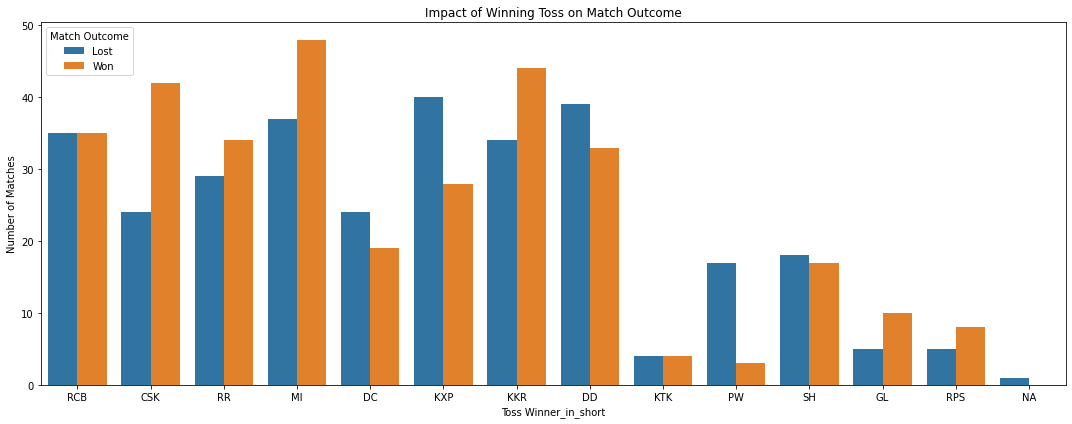

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
toss_impact_pd = toss_impact_individual_matches.toPandas()

#Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(15,6)) #defines area taken by the graph
sns.countplot(x='toss_winner_in_short', hue='match_outcome',data=toss_impact_pd)
plt.title("Impact of Winning Toss on Match Outcome")
plt.xlabel('Toss Winner_in_short')
plt.ylabel('Number of Matches')
plt.legend(title = 'Match Outcome')
# plt.xticks(rotation = 90) #to rotate x axis labels to 90 degree for better readability
plt.tight_layout()
plt.show

From this graph we can conclude that whenever CSK won toss they likely loses the game and when KXP wins toss they likely win the match 


In [0]:
scores_by_venue = spark.sql("""
     SELECT venue_name,AVG(total_runs) AS average_score, MAX(total_runs) AS highest_score
     FROM(
       SELECT ball_by_ball.match_id, match.venue_name,SUM(runs_scored) as total_runs
       FROM ball_by_ball
       JOIN match ON ball_by_ball.match_id = match.match_id
       GROUP BY ball_by_ball.match_id,match.venue_name
     )            
     GROUP BY venue_name
     ORDER BY highest_score ASC           
                            """)

scores_by_venue.display()

venue_name,average_score,highest_score
OUTsurance Oval,238.0,261
Buffalo Park,246.66666666666666,265
"Vidarbha Cricket Association Stadium, Jamtha",272.3333333333333,290
St George's Park,271.7142857142857,290
Nehru Stadium,255.4,291
New Wanderers Stadium,270.0,303
Shaheed Veer Narayan Singh International Stadium,277.1666666666667,312
De Beers Diamond Oval,285.0,319
Newlands,239.71428571428572,328
Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium,272.27272727272725,333


Out[77]: <function matplotlib.pyplot.show(close=None, block=None)>

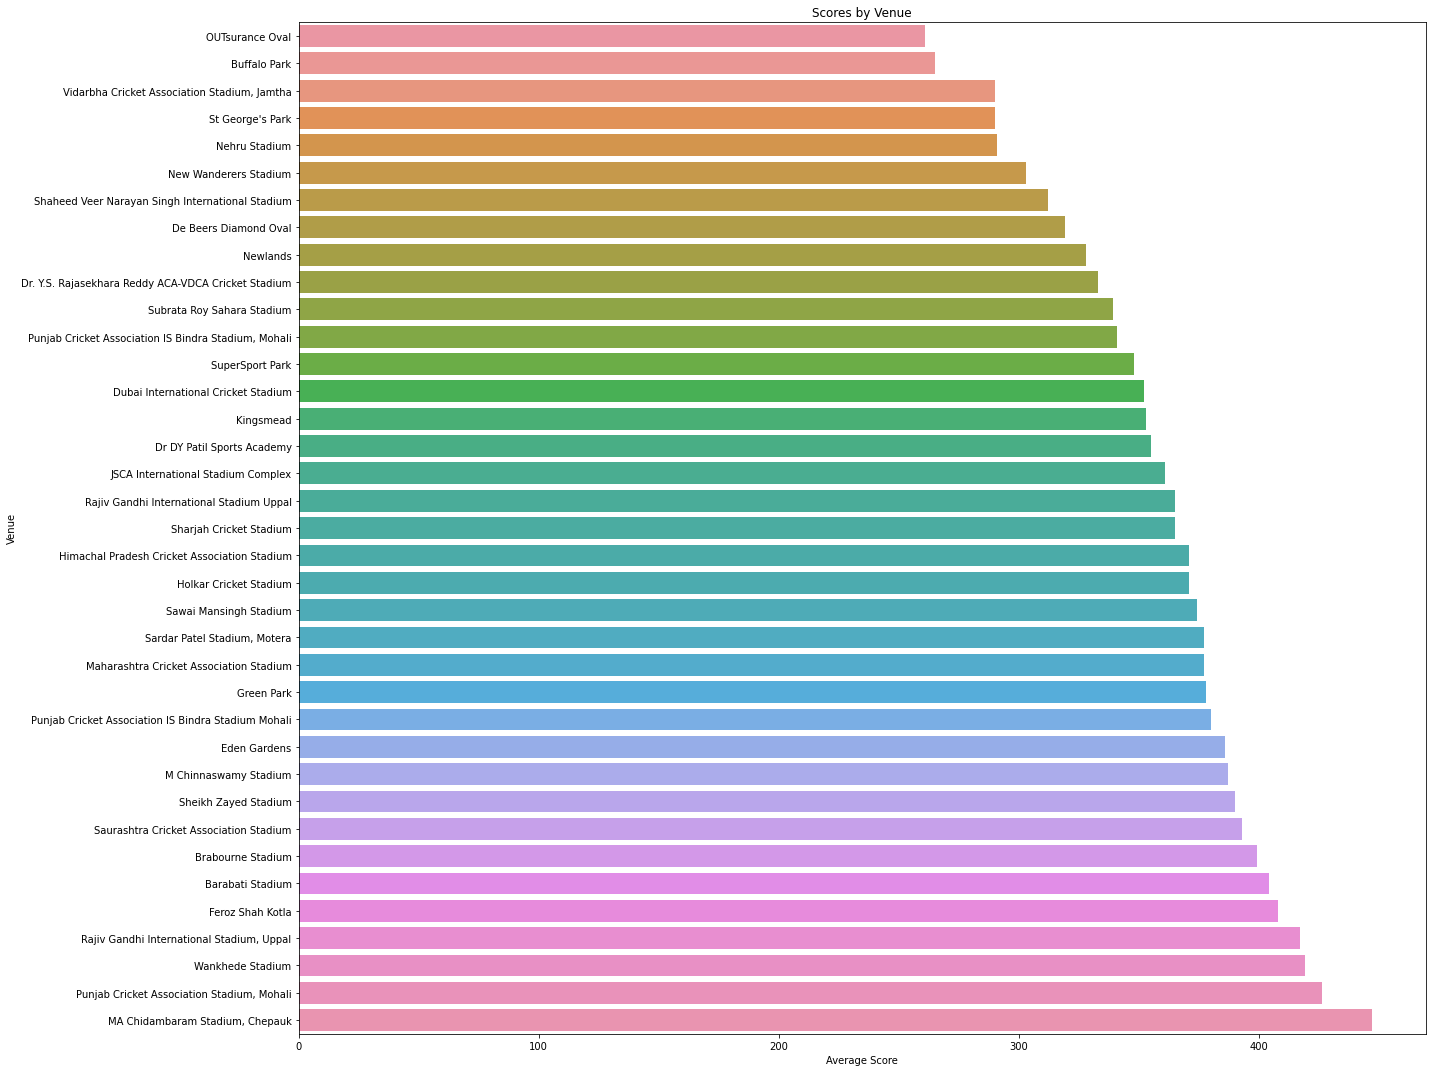

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
scores_by_venue_pd = scores_by_venue.toPandas()

# Plot
plt.figure(figsize=(20,15)) #defines area taken by the graph
bars = sns.barplot(x='highest_score', y='venue_name',data=scores_by_venue_pd)

plt.title("Scores by Venue")
plt.xlabel('Average Score')
plt.ylabel('Venue')
# plt.xticks(rotation = 90) #to rotate x axis labels to 90 degree for better readability
plt.tight_layout()
plt.show

In [0]:
team_toss_win_performance = spark.sql("""
      SELECT team1_in_short,count(*) AS matches_played,
      SUM(CASE WHEN toss_winner_in_short = match_winner_in_short THEN 1 ELSE 0 END) AS win_after_toss
      FROM match
      WHERE toss_winner_in_short = team1_in_short        
      GROUP BY team1_in_short
      ORDER BY win_after_toss                        
                                      """)
team_toss_win_performance.show()

+--------------+--------------+--------------+
|team1_in_short|matches_played|win_after_toss|
+--------------+--------------+--------------+
|           KTK|             4|             2|
|            PW|            10|             2|
|            GL|             7|             3|
|           RPS|             7|             5|
|            DC|            22|             6|
|            SH|            16|             8|
|           KXP|            32|            14|
|            RR|            25|            16|
|            DD|            36|            17|
|           RCB|            34|            19|
|           KKR|            36|            24|
|            MI|            42|            26|
|           CSK|            37|            27|
+--------------+--------------+--------------+



Out[79]: <function matplotlib.pyplot.show(close=None, block=None)>

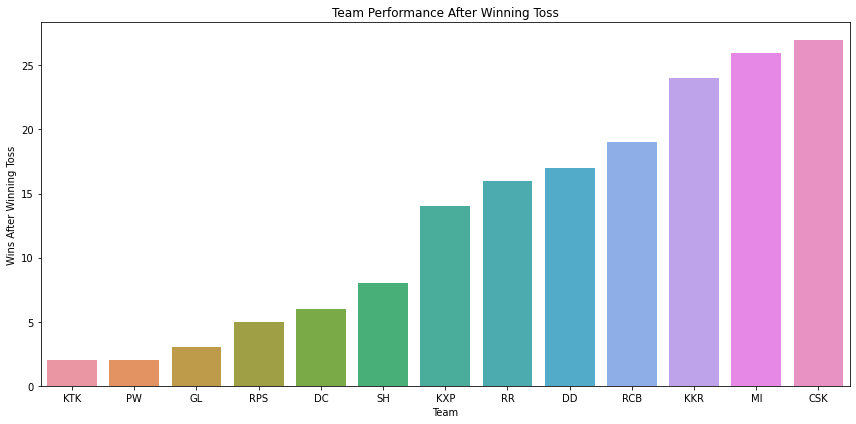

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
team_toss_win_performance_pd = team_toss_win_performance.toPandas()

#Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(12,6)) #defines area taken by the graph
sns.barplot(y='win_after_toss', x='team1_in_short',data=team_toss_win_performance_pd)
plt.title("Team Performance After Winning Toss")
plt.ylabel('Wins After Winning Toss')
plt.xlabel('Team')
# plt.xticks(rotation = 90) #to rotate x axis labels to 90 degree for better readability
plt.tight_layout()
plt.show


CSK performed the best when they won the toss

In [0]:
# match_df.display()
match_df.select("team1").distinct().show()

+--------------------+
|               team1|
+--------------------+
| Sunrisers Hyderabad|
| Chennai Super Kings|
|     Deccan Chargers|
|Kochi Tuskers Kerala|
|    Rajasthan Royals|
|       Gujarat Lions|
|Royal Challengers...|
|Kolkata Knight Ri...|
|Rising Pune Super...|
|     Kings XI Punjab|
|       Pune Warriors|
|    Delhi Daredevils|
|      Mumbai Indians|
+--------------------+



In [0]:
season_wise_team_performance = spark.sql("""
      SELECT team1, season_year,
      SUM(CASE WHEN team1 = match_winner THEN 1 ELSE 0 END) AS wins
      FROM match 
      GROUP BY team1,season_year
      ORDER BY season_year DESC                            
                                         """)
season_wise_team_performance.show()

+--------------------+-----------+----+
|               team1|season_year|wins|
+--------------------+-----------+----+
|Kolkata Knight Ri...|       2017|   4|
|     Kings XI Punjab|       2017|   4|
|      Mumbai Indians|       2017|   7|
|       Gujarat Lions|       2017|   1|
| Sunrisers Hyderabad|       2017|   6|
|    Delhi Daredevils|       2017|   4|
|Royal Challengers...|       2017|   1|
|Rising Pune Super...|       2017|   5|
|Rising Pune Super...|       2016|   2|
|Kolkata Knight Ri...|       2016|   4|
| Sunrisers Hyderabad|       2016|   5|
|       Gujarat Lions|       2016|   4|
|     Kings XI Punjab|       2016|   2|
|    Delhi Daredevils|       2016|   4|
|Royal Challengers...|       2016|   4|
|      Mumbai Indians|       2016|   3|
|    Rajasthan Royals|       2015|   4|
|    Delhi Daredevils|       2015|   3|
| Chennai Super Kings|       2015|   7|
|      Mumbai Indians|       2015|   5|
+--------------------+-----------+----+
only showing top 20 rows



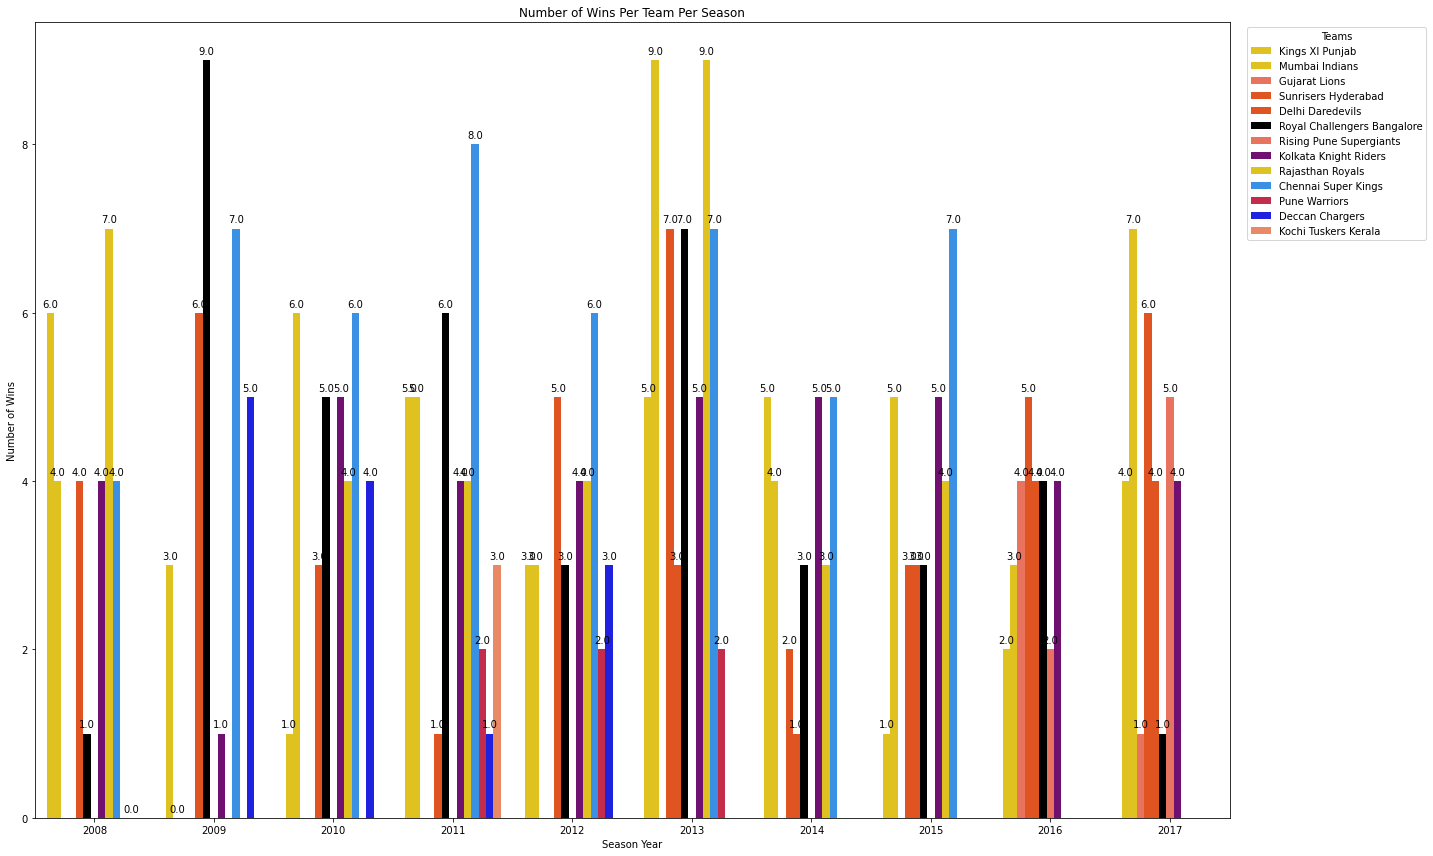

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

season_wise_team_performance_df = season_wise_team_performance.toPandas()

# Create bar plot
plt.figure(figsize=(20, 12))

# Define custom color palette 
custom_palette = custom_palette = { 
                                   'Sunrisers Hyderabad': '#FF4500', 
                                   'Chennai Super Kings': '#1E90FF', 
                                   'Deccan Chargers': '#0000FF', 
                                   'Kochi Tuskers Kerala': '#FF7F50', 
                                   'Rajasthan Royals': '#FFD700', 
                                   'Gujarat Lions': '#FF6347', 
                                   'Royal Challengers Bangalore': '#000000', 
                                   'Kolkata Knight Riders': '#800080', 
                                   'Rising Pune Supergiants': '#FF6347', 
                                   'Kings XI Punjab': '#FFD700', 
                                   'Pune Warriors': '#DC143C', 
                                   'Delhi Daredevils': '#FF4500', 
                                   'Mumbai Indians': '#FFD700' }

barplot = sns.barplot(x='season_year', y='wins', hue='team1', data=season_wise_team_performance_df, palette=custom_palette)

# Add numbers on bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.1f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Add title and labels
plt.title('Number of Wins Per Team Per Season')
plt.xlabel('Season Year')
plt.ylabel('Number of Wins')
plt.legend(title='Teams', bbox_to_anchor=(1.01, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()
